In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('gender-classifier-DFE-791531.csv', sep=',',encoding='latin-1')

np.random.seed(0)
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

train.columns
# created
# description
# fav_number
# link_color? 
# name
# profileimage
# sidebar_color
# text
# tweet_count

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

# Data Transformations

In [3]:
# DROP NON MALE / FEMALE
genders = list(train.gender)
print(np.unique(genders))
train_drop = train[train.gender.notnull()]
train_drop = train_drop[train_drop.gender != 'brand']
train_drop = train_drop[train_drop.gender != 'unknown']
train_drop.loc[train_drop.gender == 'female', 'gender'] = 0 
train_drop.loc[train_drop.gender == 'male', 'gender'] = 1 
train_drop.shape
genders = list(train_drop.gender)
train = train_drop
print(np.unique(genders))
print(train_drop.shape)

['brand' 'female' 'male' 'nan' 'unknown']
[0 1]
(10320, 26)


In [4]:
# CHANGE ACCOUNT CREATION DATE TO TIME SINCE CREATION
import datetime
def get_length(s):
    year = s.split('/')[2]
    month = s.split('/')[0]
    day = s.split('/')[1]
    return datetime.date(17, 10, 1) - datetime.date(int(year), int(month), int(day))
created = train.created
created = [el.split()[0] for el in created]
c = [get_length(s) for s in created]
months = [el.days/30 for el in c]
train.created = months

In [5]:
# Validation Set
np.random.seed(1)
msk = np.random.rand(len(train)) < 0.8
validation = train[~msk]
train = train[msk]


# Binary Classification

In [6]:
# First pass
first_pass_X_train = train.filter(['created', 'fav_number'],axis=1)
first_pass_y_train = list(train.gender)

first_pass_X_val = validation.filter(['created', 'fav_number'],axis=1)
first_pass_y_val = list(validation.gender)

In [7]:
import sklearn.linear_model
first = sklearn.linear_model.LogisticRegression()
first.fit(first_pass_X_train, first_pass_y_train)
scores = first.predict_proba(first_pass_X_val)

0.5551338905


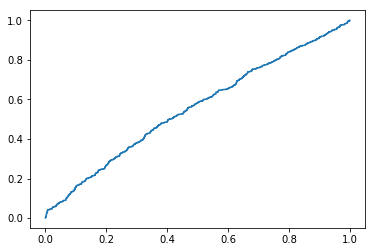

In [8]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(first_pass_y_val, scores[:,1])
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
print (metrics.roc_auc_score(first_pass_y_val, scores[:,1]))

# Adding in the categorical variables

In [9]:
X_train = train.filter(['created',  'fav_number'],axis=1)
y_train = list(train.gender)

X_val = validation.filter(['created',  'fav_number'],axis=1)
y_val = list(validation.gender)

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

In [10]:
categories = np.union1d(train.sidebar_color, validation.sidebar_color)
train_side = train.sidebar_color.astype('category', categories=categories)
val_side = validation.sidebar_color.astype('category', categories=categories)

sidebar_color = pd.get_dummies(train_side)
sidebar_color_val = pd.get_dummies(val_side)

categories = np.union1d(train.link_color, validation.link_color)
train_link = train.link_color.astype('category', categories=categories)
val_link = validation.link_color.astype('category', categories=categories)

dummies_link = pd.get_dummies(train_link)
dummies_link_val = pd.get_dummies(val_link)

print(X_train.shape, sidebar_color.shape, dummies_link.shape)
print(X_val.shape, sidebar_color_val.shape, dummies_link_val.shape)

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
sidebar_color.reset_index(drop=True, inplace=True)
sidebar_color_val.reset_index(drop=True, inplace=True)
dummies_link.reset_index(drop=True, inplace=True)
dummies_link_val.reset_index(drop=True, inplace=True)

X_train = pd.concat([X_train, sidebar_color, dummies_link],axis=1, ignore_index=True)
X_val = pd.concat([X_val, sidebar_color_val, dummies_link_val],axis=1, ignore_index=True)

print(X_train.shape)
print(X_val.shape)

(8297, 2) (8297, 342) (8297, 1733)
(2023, 2) (2023, 342) (2023, 1733)
(8297, 2077)
(2023, 2077)


0.654523987367


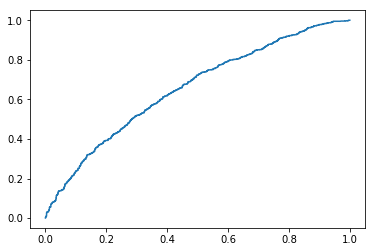

In [11]:
second = sklearn.linear_model.LogisticRegression()
second.fit(X_train,y_train)
scores = second.predict_proba(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, scores[:,1])
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
print (metrics.roc_auc_score(y_val, scores[:,1]))

# Adding Text based features

In [12]:
import sklearn.feature_extraction
tdidf = sklearn.feature_extraction.text.TfidfVectorizer()
tdidf.max_features = 60
texts = list(df.text)
tdidf.fit(texts)
texts_train = tdidf.fit_transform(train.text)
texts_val = tdidf.fit_transform(validation.text)
tdidf_train = pd.DataFrame(texts_train.toarray(), columns=tdidf.get_feature_names())
tdidf_val = pd.DataFrame(texts_val.toarray(), columns=tdidf.get_feature_names())


X_train.reset_index(drop=True, inplace=True)
tdidf_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
tdidf_val.reset_index(drop=True, inplace=True)

X_train = pd.concat([X_train, tdidf_train],axis=1, ignore_index=True)
X_val = pd.concat([X_val, tdidf_val],axis=1, ignore_index=True)

X_train.shape

(8297, 2137)

0.666721559909


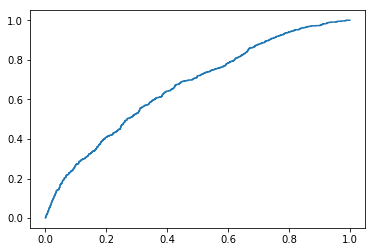

In [13]:
second = sklearn.linear_model.LogisticRegression()
second.fit(X_train,y_train)
scores = second.predict_proba(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, scores[:,1])
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
print (metrics.roc_auc_score(y_val, scores[:,1]))

# Adding Username Features

In [14]:
def n_grams(s):
    left = 0
    right = 0 + 5
    r = []
    while right < len(s):
        r.append(s[left:right])
        left += 1
        right += 1
    return " ".join(r)

In [15]:
import sklearn.feature_extraction
tdidf = sklearn.feature_extraction.text.TfidfVectorizer()
tdidf.max_features = 100
names = [n_grams(s) for s in list(df.name)]
tdidf.fit(names)
names_train = tdidf.fit_transform([n_grams(s) for s in train.name])
names_val = tdidf.fit_transform([n_grams(s) for s in validation.name])
tdidf_train = pd.DataFrame(names_train.toarray(), columns=tdidf.get_feature_names())
tdidf_val = pd.DataFrame(names_val.toarray(), columns=tdidf.get_feature_names())


X_train.reset_index(drop=True, inplace=True)
tdidf_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
tdidf_val.reset_index(drop=True, inplace=True)

X_train = pd.concat([X_train, tdidf_train],axis=1, ignore_index=True)
X_val = pd.concat([X_val, tdidf_val],axis=1, ignore_index=True)

X_train.shape

(8297, 2237)

0.669483866288


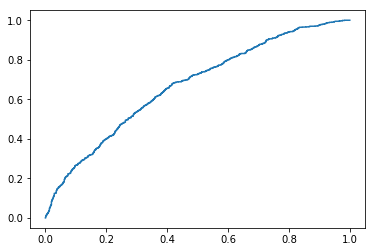

In [16]:
third = sklearn.linear_model.LogisticRegression()
third.fit(X_train,y_train)
scores = third.predict_proba(X_val)
fpr, tpr, thresholds = metrics.roc_curve(y_val, scores[:,1])
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
print (metrics.roc_auc_score(y_val, scores[:,1]))

# Continuous

In [17]:
'''
tg = train.gender
vg = validation.gender
X_train.reset_index(drop=True, inplace=True)
tg.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
vg.reset_index(drop=True, inplace=True)

X_train = pd.concat([X_train, tg],axis=1, ignore_index=True)
X_val = pd.concat([X_val, vg],axis=1, ignore_index=True)
'''

'\ntg = train.gender\nvg = validation.gender\nX_train.reset_index(drop=True, inplace=True)\ntg.reset_index(drop=True, inplace=True)\nX_val.reset_index(drop=True, inplace=True)\nvg.reset_index(drop=True, inplace=True)\n\nX_train = pd.concat([X_train, tg],axis=1, ignore_index=True)\nX_val = pd.concat([X_val, vg],axis=1, ignore_index=True)\n'

In [18]:
y_train = train.filter(['tweet_count'])
y_val = validation.filter(['tweet_count'])

In [19]:
#X_train = train.filter(['created'])
#X_val = validation.filter(['created'])

In [23]:
import sklearn.neural_network
third = sklearn.linear_model.Ridge(alpha=100)
third.fit(X_train,y_train)

print(third.score(X_train,y_train))

scores = third.predict(X_val)

print (metrics.mean_squared_error(y_val, scores))
print (metrics.mean_squared_error(y_val, [np.mean(y_val) for i in range(len(y_val))]))

0.0908441673219
6459908217.66
6872329920.71


In [21]:
y_train

,tweet_count
0,110964
1,7471
2,5617
3,1693
4,31462
5,20036
9,26085
12,13585
14,18469
15,44421


In [22]:
third.predict(X_val)

array([[ 11675.46693824],
       [ 31370.07264452],
       [ 26714.23392736],
       ..., 
       [ 44537.12090998],
       [ 20121.429192  ],
       [ 34062.15582769]])